# Linear Regression

Linear Regression Bond Pricing Models

author: Maris

## Libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime as dt
import os
import seaborn as sns
import random 
from scipy.optimize import newton
import itertools
import seaborn as sns

In [103]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import ensemble

In [105]:
import warnings
warnings.filterwarnings('ignore')

In [106]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [107]:
pd.set_option('display.max_columns', None)

In [108]:
os.chdir('/Users/maris/Documents/FE800')

In [109]:
np.random.seed(10)

## Import Data

In [9]:
df_characteristics = pd.read_pickle("df_characteristics_full.pkl")
df_characteristics.head()

,Name,Cusip,Maturity,TTM,Coupon,Weight,Amount_Issued,Industry,Location,Accrual_Date,Effective_Date,Moody_Rating,S&P_Rating,Fitch_Rating,TTM_Range,TFI,Company,Ticker,Sector,Sector Ticker,Cpn_Range,TFI_Range
279,AT&T INC,00206RBH4,2042-12-15,19.0219,4.30,0.04,750000000,Communications,United States,2013-06-15,2013-06-18,Baa3,BBB-,BBB-,15-20 Years,10.4904,At&T,T,Communications,XLY,NaN,10-15 Years
463,AT&T INC,00206RBK7,2045-06-15,21.5233,4.35,0.03,900000000,Communications,United States,2013-06-15,2013-06-18,Aa2,A+,None,20+ Years,10.4904,At&T,T,Communications,XLY,NaN,10-15 Years
61,AT&T INC,00206RCP5,2035-05-15,11.4301,4.50,0.07,2250000000,Communications,United States,2015-05-04,2015-05-04,A3,BBB+,A,10-15 Years,8.6137,At&T,T,Communications,XLY,4%,7-10 Years
167,AT&T INC,00206RCQ3,2046-05-15,22.4384,4.75,0.05,1727815000,Communications,United States,2015-05-04,2015-05-04,Baa1,BBB+,None,20+ Years,8.6137,At&T,T,Communications,XLY,3%,7-10 Years
595,AT&T INC,00206RCU4,2047-02-15,23.1945,5.65,0.02,1500000000,Communications,United States,2016-02-09,2016-02-09,A3,A-,A,20+ Years,7.8438,At&T,T,Communications,XLY,NaN,7-10 Years


In [110]:
df = pd.read_pickle("factor_df.pkl")
df.head()

Return      Price    volume    Trades       TTM  \
cusip     trd_dt                                                          
00206RBH4 2018-07-03  0.008850  86.513796 -0.785507 -0.940150  1.728678   
          2018-07-05  0.003406  86.808383 -0.573559  1.089431  1.724879   
          2018-07-06  0.004973  87.240021 -0.637707 -0.462601  1.722980   
          2018-07-09 -0.001021  87.150785 -0.115591 -0.940150  1.717283   
          2018-07-10  0.002972  87.409758 -0.519514 -0.462601  1.715383   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   
          2018-07-10      0.010887      0.103056    0.002150 -0.001502   

                           YTM  Duration      DV01  Convexity  
cusip     trd_dt                                               
00206RBH4 2018-07-03  0.902753  1.131115  0.498639   1.391850  
          2018-07-05  0.878724  1.132837  0.478094   1.392504  
          2018-07-06  0.841574  1.137649  0.447232   1.395884  
          2018-07-09  0.852737  1.113003  0.461360   1.375882  
          2018-07-10  0.830979  1.102112  0.447388   1.367151

In [111]:
df.shape

(945768, 13)

In [112]:
macro_factors = pd.read_pickle("macro_factors.pkl").drop(["Lower_Target", "Upper_Target"], axis = 1)
factor_returns = macro_factors.pct_change().drop(pd.Timestamp("2018-07-02"))
factor_returns.head()

,EFFR,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,SPY,LQD
2018-07-03,0.0,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
2018-07-05,0.0,-0.004292,0.007905,0.007605,0.007353,0.003584,0.003534,-0.003378,0.008158,0.003140
2018-07-06,0.0,0.008621,-0.007843,-0.003774,-0.010949,-0.007143,-0.007042,-0.003390,0.008458,0.001391
2018-07-09,0.0,0.000000,0.015810,0.007576,0.014760,0.014388,0.014184,0.006803,0.009004,0.000695
2018-07-10,0.0,0.008547,0.007782,0.011278,0.007273,0.003546,0.003497,0.003378,0.003598,-0.001128


## Factor Analysis

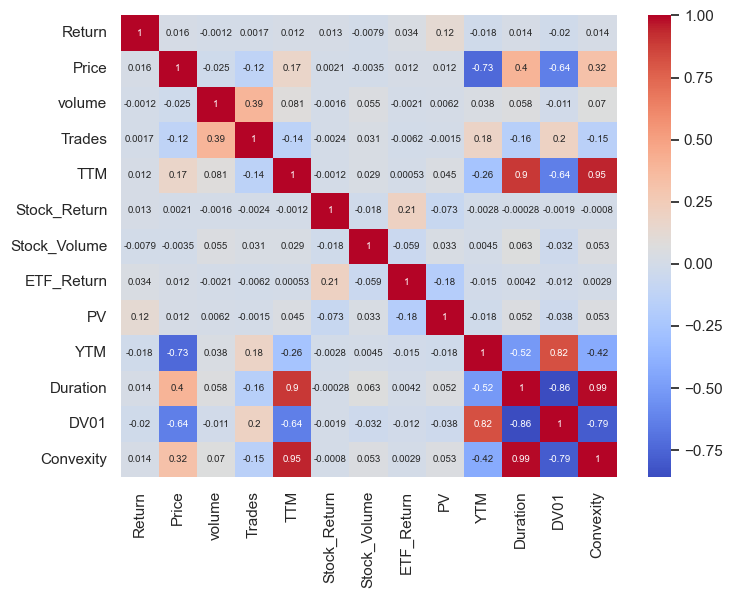

In [113]:
plt.figure(figsize = [8,6])
sns.heatmap(df.corr(), annot = True, annot_kws={"size": 7}, cmap='coolwarm')
plt.show()

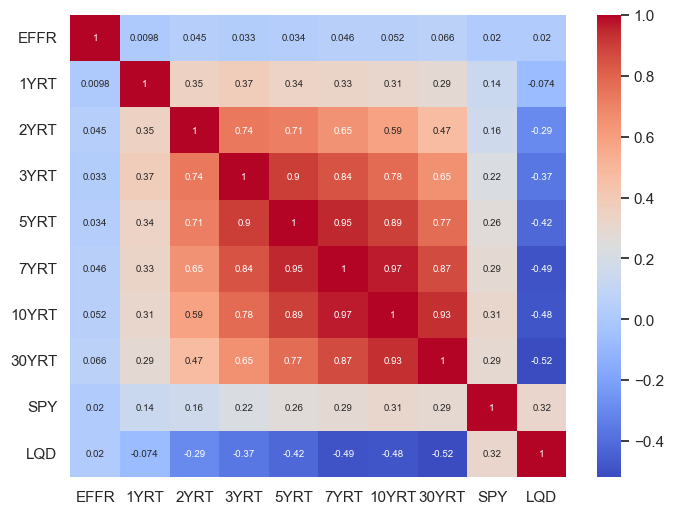

In [114]:
plt.figure(figsize = [8,6])
sns.heatmap(factor_returns.corr(), annot = True, annot_kws={"size": 7}, cmap='coolwarm')
plt.show()

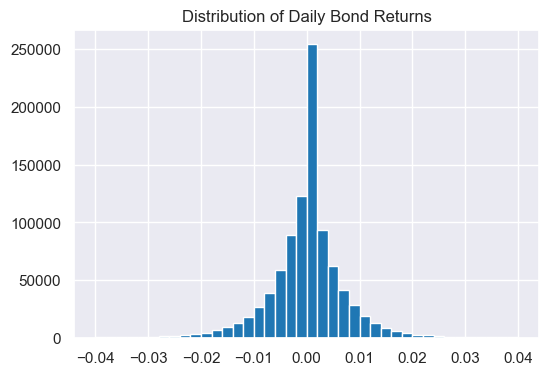

In [115]:
fig, ax = plt.subplots(1, 1, figsize = [6,4])

ax.hist(df["Return"], bins = 40, range = [-.04, .04])
ax.set_title("Distribution of Daily Bond Returns")

plt.show()

In [116]:
factor_concatenated = pd.concat([factor_returns] * 753, ignore_index=True)
factor_concatenated.index = df.index
factor_concatenated.head()

EFFR      1YRT      2YRT      3YRT      5YRT      7YRT  \
cusip     trd_dt                                                               
00206RBH4 2018-07-03   0.0 -0.004274 -0.015564 -0.007547 -0.010909 -0.014134   
          2018-07-05   0.0 -0.004292  0.007905  0.007605  0.007353  0.003584   
          2018-07-06   0.0  0.008621 -0.007843 -0.003774 -0.010949 -0.007143   
          2018-07-09   0.0  0.000000  0.015810  0.007576  0.014760  0.014388   
          2018-07-10   0.0  0.008547  0.007782  0.011278  0.007273  0.003546   

                         10YRT     30YRT       SPY       LQD  
cusip     trd_dt                                              
00206RBH4 2018-07-03 -0.013937 -0.010033 -0.003531  0.003677  
          2018-07-05  0.003534 -0.003378  0.008158  0.003140  
          2018-07-06 -0.007042 -0.003390  0.008458  0.001391  
          2018-07-09  0.014184  0.006803  0.009004  0.000695  
          2018-07-10  0.003497  0.003378  0.003598 -0.001128

In [117]:
df_factor_concatenated = pd.concat([df, factor_concatenated], axis = 1)
df_factor_concatenated = df_factor_concatenated.sort_values("trd_dt")
df_factor_concatenated = df_factor_concatenated.reset_index()
df_factor_concatenated.head()

,cusip,trd_dt,Return,Price,volume,Trades,TTM,Stock_Return,Stock_Volume,ETF_Return,PV,YTM,Duration,DV01,Convexity,EFFR,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,SPY,LQD
0,00206RBH4,2018-07-03,8.850444e-03,86.513796,-0.785507,-0.940150,1.728678,0.015523,-0.171355,-0.005025,0.004849,0.902753,1.131115,0.498639,1.391850,0.0,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
1,47233JAG3,2018-07-03,1.323889e-03,97.664615,-0.649333,-0.567722,1.728678,0.002222,-0.344703,-0.011842,0.002833,1.029444,1.579962,-1.086974,1.834026,0.0,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
2,71644EAJ1,2018-07-03,7.288542e-07,94.210257,NaN,NaN,1.728678,0.003468,-0.969400,-0.012239,0.005144,NaN,1.148909,NaN,1.404106,0.0,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
3,20030NBW0,2018-07-03,5.129044e-03,88.220008,-0.573048,-1.472566,1.728678,-0.002412,-0.915296,0.002342,0.003070,0.976918,1.640723,-1.033389,1.883263,0.0,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
4,00287YAS8,2018-07-03,6.482978e-07,94.773054,NaN,NaN,1.728678,0.005370,-1.082663,-0.008982,0.005048,NaN,0.873643,NaN,1.194560,0.0,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677


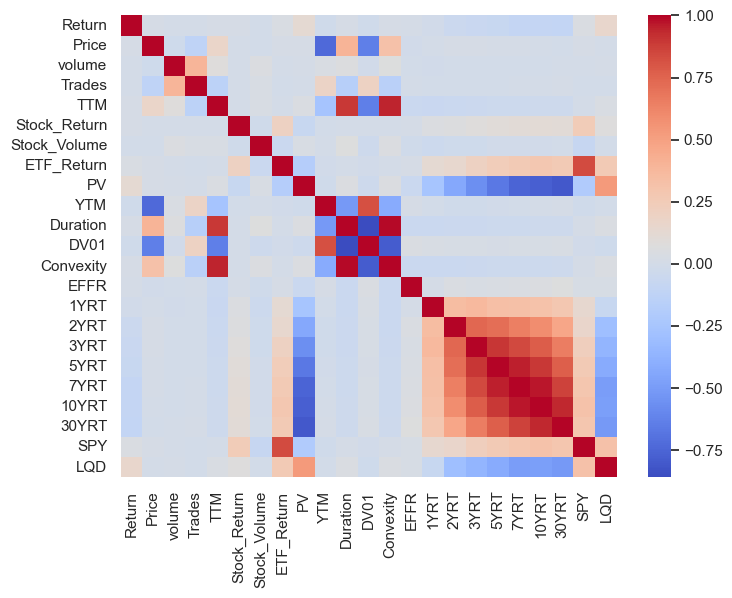

In [118]:
plt.figure(figsize = [8,6])
sns.heatmap(df_factor_concatenated.drop(["cusip", "trd_dt"], axis = 1).corr(), cmap='coolwarm')
plt.show()

# OLS Regression

In [119]:
def aggregate_OLS(df, feature):

    df = df.dropna()
    df = df.reset_index()
    indexer = df[df["trd_dt"] == pd.Timestamp("2022-06-01")].index[0]
    X = df.drop(["cusip", "trd_dt", feature, "Price"], axis = 1)
    Y = df[feature]
    
    X_train = X.iloc[:indexer]
    X_test = X.iloc[indexer:]
    Y_train = Y.iloc[:indexer]
    Y_test = Y.iloc[indexer:]

    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    X0 = sm.add_constant(X)
    model_output = sm.OLS(Y, X0).fit()

    fig, ax = plt.subplots(1, 3, figsize = [18,5])
    fig.autofmt_xdate(rotation=45)

    print(model_output.summary())

    ax[0].scatter(Y_pred, Y_test - Y_pred)
    ax[0].set_title("Homoskedasticity of Residuals")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residual")

    ax[1].scatter(Y_pred, Y_test)
    ax[1].set_title("Predictions vs Actual Values")
    ax[1].set_xlabel("Prediction")
    ax[1].set_ylabel("Actual")
    
    ax[2].scatter(Y_test.index, Y_test - Y_pred)
    ax[2].set_title("Distribution of Residuals")
    ax[2].set_ylabel("Residual")

    plt.show()
        
    r2_train = model.score(X_train, Y_train)
    r2_test = r2_score(Y_test, Y_pred)
        
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = mean_squared_error(Y_test, Y_pred, squared=False)
    mae = mean_absolute_error(Y_test, Y_pred)

    return r2_train, r2_test, mse, rmse, mae

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1165.
Date:                Sun, 17 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:49:07   Log-Likelihood:             1.6502e+06
No. Observations:              792897   AIC:                        -3.300e+06
Df Residuals:                  792874   BIC:                        -3.300e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0601      0.022      2.783   

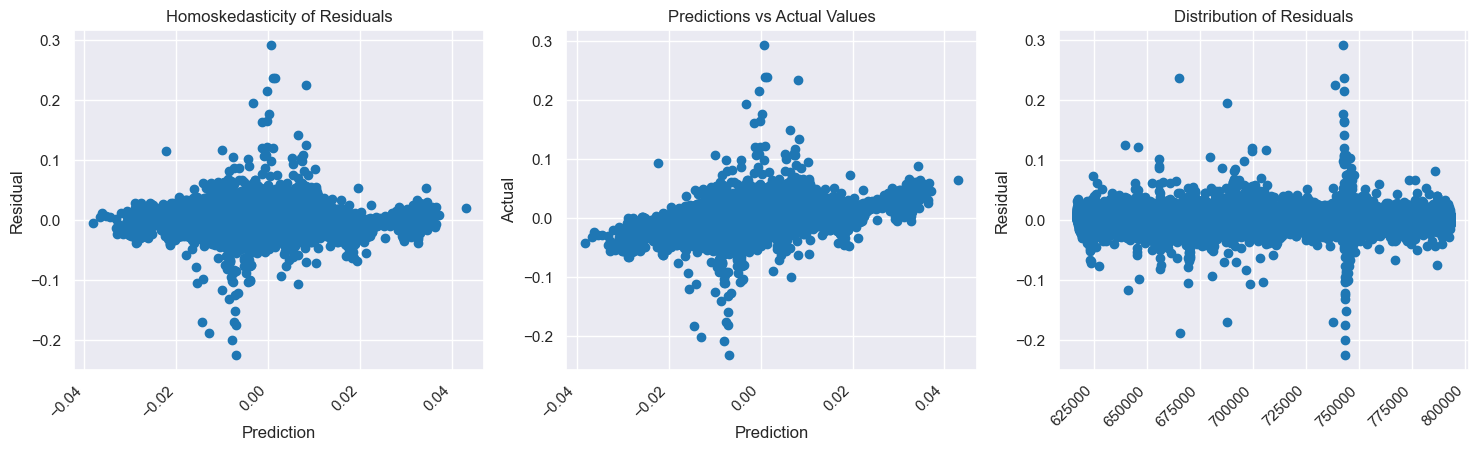

(0.023579154565029237,
 0.3275430229803752,
 6.182615279191309e-05,
 0.007862960815870386,
 0.005339385212542092)

In [120]:
aggregate_OLS(df_factor_concatenated, "Return")

In [121]:
def OLS(df, feature, output = True, price = True, aggregate = False):
        
    if price == "True":
        X = df.drop([feature, "Price"], axis = 1)[1:].dropna(how = "all", axis = 1).fillna(0)
    else:
        X = df.drop([feature], axis = 1)[1:].dropna(how = "all", axis = 1).fillna(0)

    Y = df[feature][1:].fillna(0)
    
    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]
        
    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    X0 = sm.add_constant(X)
    model_output = sm.OLS(Y, X0).fit()

    if output == "True":

        fig, ax = plt.subplots(1, 4, figsize = [24,5])
        fig.autofmt_xdate(rotation=45)
 
        print(model_output.summary())
    
        ax[0].scatter(Y_pred, Y_test - Y_pred)
        ax[0].set_title("Homoskedasticity of Residuals")
        ax[0].set_xlabel("Prediction")
        ax[0].set_ylabel("Residual")
    
        ax[1].scatter(Y_pred, Y_test)
        ax[1].set_title("Predictions vs Actual Values")
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Actual")
        
        ax[2].scatter(Y_test.index, Y_test - Y_pred)
        ax[2].set_title("Distribution of Residuals")
        ax[2].set_ylabel("Residual")

        ax[3].hist(Y_test - Y_pred)
        ax[3].set_title("Distribution of Residuals")
        ax[3].set_ylabel("Residual")
    
        plt.show()

    else:
        
        r2_train = model.score(X_train, Y_train)
        r2_test = r2_score(Y_test, Y_pred)

        prices = pd.DataFrame({"Test": df["Price"].loc[pd.Timestamp("2022-06-01"):]}).ffill()
        prices["Return Pred"] = Y_pred + 1

        pred = []
        for i in range(len(prices)):
            if i == 0:
                pred.append(prices["Return Pred"].iloc[0] * df["Price"].loc[pd.Timestamp("2022-05-31")])
            else:
                pred.append(prices["Return Pred"].iloc[i] * prices["Test"].iloc[i - 1])
        prices["Pred"] = pred
        prices["Pred"] = prices["Pred"].ffill()

        try:
        
            mse = mean_squared_error(prices["Test"], prices["Pred"])
            rmse = mean_squared_error(prices["Test"], prices["Pred"], squared=False)
            mae = mean_absolute_error(prices["Test"], prices["Pred"])
        
            return r2_train, r2_test, mse, rmse, mae

        except:
            return None, None, None, None, None

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     14.76
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           9.92e-49
Time:                        17:49:08   Log-Likelihood:                 3716.7
No. Observations:                1255   AIC:                            -7387.
Df Residuals:                    1232   BIC:                            -7269.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0271      0.012     -2.321   

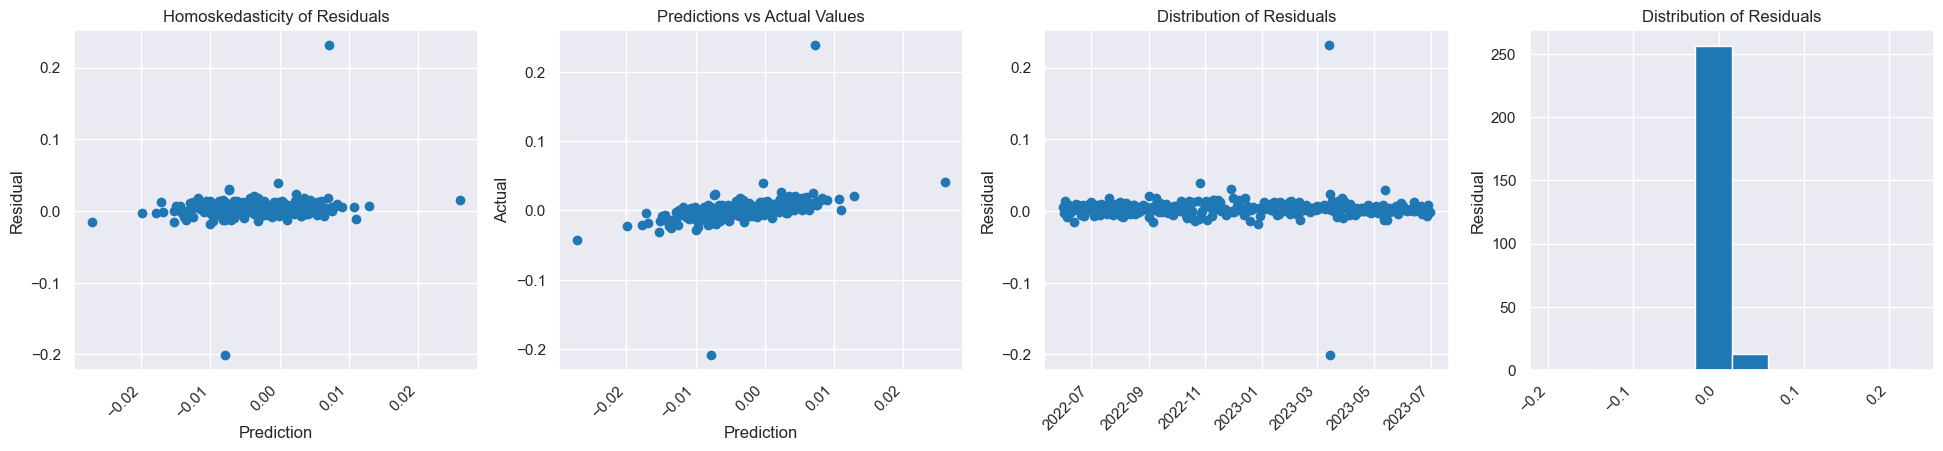

In [122]:
OLS(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], factor_returns], axis = 1), "Return", output = "True")

In [123]:
%%time

ols_results = pd.DataFrame(columns = ["Cusip", "R2 Train", "R2 Test", "MSE", "RMSE", "MAE"])
for col in list(df.index.droplevel(1).unique()):
    outputs = OLS(pd.concat([df.loc[col], factor_returns], axis = 1), "Return", output = False)
    ols_results.loc[len(ols_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3], outputs[4]]

CPU times: user 4min 27s, sys: 8min 57s, total: 13min 25s
Wall time: 1min 12s


In [124]:
ols_results.sort_values("R2 Test").dropna()

,Cusip,R2 Train,R2 Test,MSE,RMSE,MAE
719,92976GAJ0,0.018293,-558.627944,586.857177,24.225135,21.123447
247,26441CAX3,0.311238,-10.416259,1.490491,1.220857,0.364343
566,72650RBL5,0.219389,-7.706188,1.516464,1.231448,1.071647
513,654106AF0,0.114841,-4.257926,0.634465,0.796533,0.614121
324,38141GFD1,0.034957,-4.188838,6.884316,2.623798,2.010228
...,...,...,...,...,...,...
690,91324PDK5,0.497599,0.623530,0.071726,0.267816,0.211532
10,002824BG4,0.476681,0.632760,0.250749,0.500748,0.384411
212,20030NCJ8,0.493009,0.634657,0.229806,0.479381,0.355483
295,369550BC1,0.453410,0.664523,0.062171,0.249342,0.192783


In [125]:
len(ols_results[ols_results["R2 Test"] > 0])/len(ols_results)

0.8220451527224436

In [126]:
ols_results.drop(["Cusip"], axis = 1).mean(axis = 0)

R2 Train    0.320257
R2 Test    -0.601429
MSE         1.388207
RMSE        0.745157
MAE         0.551690
dtype: float64

# Lasso Regression

In [127]:
X = df.drop(["Return"], axis = 1).fillna(0)
vif_factors = pd.DataFrame()
vif_factors["Variable"] = X.columns
vif_factors["Variance Inflation"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_factors = vif_factors.sort_values("Variance Inflation", ascending = False)
vif_factors["Color"] = c20[:12]
vif_factors

,Variable,Variance Inflation,Color
11,Convexity,317.542986,#1f77b4
9,Duration,200.856052,#aec7e8
3,TTM,30.510155,#ff7f0e
10,DV01,9.480775,#ffbb78
8,YTM,5.062559,#2ca02c
2,Trades,1.257830,#98df8a
1,volume,1.212515,#d62728
6,ETF_Return,1.079216,#ff9896
4,Stock_Return,1.043906,#9467bd
7,PV,1.040469,#c5b0d5


In [128]:
multicolinear_columns = vif_factors[vif_factors["Variance Inflation"] > 10]["Variable"].to_list()
multicolinear_columns

['Convexity', 'Duration', 'TTM']

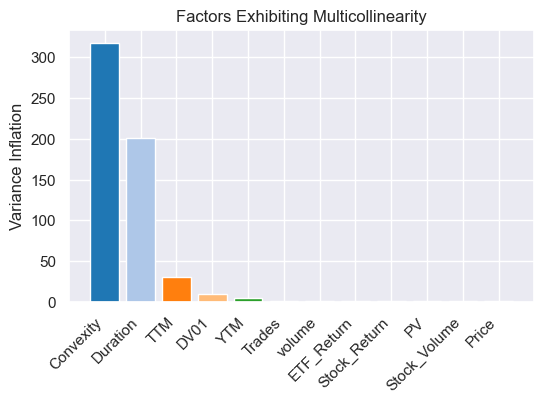

In [129]:
fig, ax = plt.subplots(figsize = [6,4])
fig.autofmt_xdate(rotation = 45)
plt.bar(vif_factors.Variable, vif_factors["Variance Inflation"], color = vif_factors["Color"])
plt.ylabel('Variance Inflation')
plt.title('Factors Exhibiting Multicollinearity')
plt.show()

In [130]:
vif_macro = pd.DataFrame()
vif_macro["Variable"] = factor_returns.dropna().columns
vif_macro["Variance Inflation"] = [variance_inflation_factor(factor_returns.dropna().values, i) for i in range(factor_returns.dropna().shape[1])]
vif_macro = vif_macro.sort_values("Variance Inflation", ascending = False)
vif_macro.head()

,Variable,Variance Inflation
5,7YRT,33.982604
6,10YRT,33.664195
4,5YRT,17.230191
7,30YRT,10.527155
3,3YRT,6.184717


In [131]:
multicolinear_macro_columns = vif_macro[vif_macro["Variance Inflation"] > 10]["Variable"].to_list()
multicolinear_macro_columns

['7YRT', '10YRT', '5YRT', '30YRT']

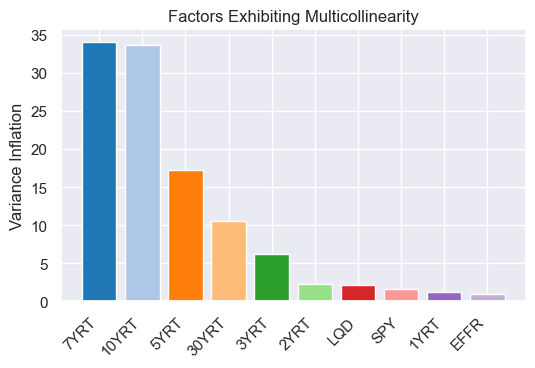

In [132]:
fig, ax = plt.subplots(figsize = [6,4])
fig.autofmt_xdate(rotation = 45)
plt.bar(vif_macro.Variable, vif_macro["Variance Inflation"], color = vif_factors["Color"])
plt.ylabel('Variance Inflation')
plt.title('Factors Exhibiting Multicollinearity')
plt.show()

In [133]:
vif = pd.concat([vif_macro, vif_factors], axis = 0)
vif = vif.sort_values("Variance Inflation", ascending = False).reset_index().drop(["index"], axis = 1)
vif["Color"] = c20 + c20[:2]
vif.head(10)

,Variable,Variance Inflation,Color
0,Convexity,317.542986,#1f77b4
1,Duration,200.856052,#aec7e8
2,7YRT,33.982604,#ff7f0e
3,10YRT,33.664195,#ffbb78
4,TTM,30.510155,#2ca02c
5,5YRT,17.230191,#98df8a
6,30YRT,10.527155,#d62728
7,DV01,9.480775,#ff9896
8,3YRT,6.184717,#9467bd
9,YTM,5.062559,#c5b0d5


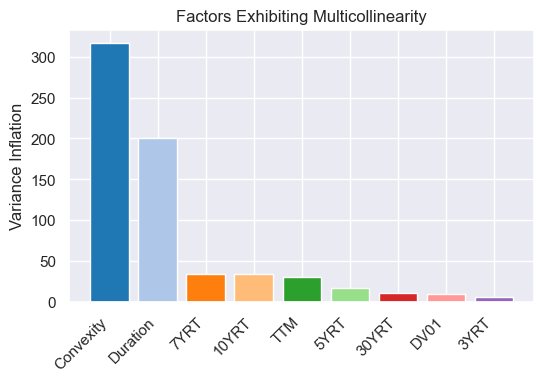

In [134]:
fig, ax = plt.subplots(figsize = [6,4])
fig.autofmt_xdate(rotation = 45)
plt.bar(vif.head(9)["Variable"], vif.head(9)["Variance Inflation"], color = vif.head(9)["Color"])
plt.ylabel('Variance Inflation')
plt.title('Factors Exhibiting Multicollinearity')
plt.show()

In [135]:
def run_lasso_regression(df, feature):

    X = df.drop([feature, "Price"], axis=1)[1:].fillna(0)
    Y = df[feature][1:].fillna(0)

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    lasso_model = LassoCV(alphas = np.random.randint(0, 1000,100), cv = 10, max_iter = 100000).fit(X_train, Y_train)
    lasso_tuned = Lasso().set_params(alpha = lasso_model.alpha_).fit(X_train, Y_train)
    Y_pred = lasso_tuned.predict(X_test)

    r2_train = lasso_model.score(X_train, Y_train)
    r2_test = r2_score(Y_test, Y_pred)

    prices = pd.DataFrame({"Test": df["Price"].loc[pd.Timestamp("2022-06-01"):]}).ffill()
    prices["Return Pred"] = Y_pred + 1

    pred = []
    for i in range(len(prices)):
        if i == 0:
            pred.append(prices["Return Pred"].iloc[0] * df["Price"].loc[pd.Timestamp("2022-05-31")])
        else:
            pred.append(prices["Return Pred"].iloc[i] * prices["Test"].iloc[i - 1])
    prices["Pred"] = pred
    
    try:
        mse = mean_squared_error(prices["Test"], prices["Pred"])
        rmse = mean_squared_error(prices["Test"], prices["Pred"], squared=False)
        mae = mean_absolute_error(prices["Test"], prices["Pred"])
    
        return r2_train, r2_test, mse, rmse, mae

    except:
        return None, None, None, None, None

In [136]:
%%time

lasso_results = pd.DataFrame(columns = ["Cusip", "R2 Train", "R2 Test", "MSE", "RMSE", "MAE"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_lasso_regression(pd.concat([df.loc[col], factor_returns], axis = 1), "Return")
    lasso_results.loc[len(lasso_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3], outputs[4]]

CPU times: user 22min 36s, sys: 41min 43s, total: 1h 4min 20s
Wall time: 7min 21s


In [137]:
lasso_results.sort_values("R2 Test").dropna()

,Cusip,R2 Train,R2 Test,MSE,RMSE,MAE
719,92976GAJ0,0.000000,-7.132989,8.783044,2.963620,2.779581
303,37045VAK6,0.301089,-0.601673,1.224169,1.106422,0.935784
324,38141GFD1,0.000000,-0.268975,1.788020,1.337169,0.916768
345,406216AY7,0.243430,-0.263600,1.176341,1.084593,0.876688
747,96949LAE5,0.420952,-0.129655,0.943442,0.971309,0.774762
...,...,...,...,...,...,...
372,458140AN0,0.408599,0.513799,0.250775,0.500774,0.386501
536,68389XBJ3,0.524501,0.560235,0.285232,0.534071,0.403583
71,037833DK3,0.332519,0.576991,0.080420,0.283584,0.183519
139,12189LAW1,0.489115,0.578811,0.368508,0.607049,0.469211


In [138]:
len(lasso_results[lasso_results["R2 Test"] > 0])/len(lasso_results)

0.06905710491367861

In [139]:
lasso_results.drop(["Cusip"], axis = 1).mean(axis = 0)

R2 Train    0.025169
R2 Test     0.007971
MSE         0.719068
RMSE        0.790046
MAE         0.550956
dtype: float64

# Ridge Regression

In [140]:
def run_ridge_regression(df, feature):
    
    X = df.drop([feature, "Price"], axis=1)[1:].fillna(0)
    Y = df[feature][1:].fillna(0)

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    ridge_model = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10).fit(X_train, Y_train)
    ridge_tuned = Ridge(alpha=ridge_model.alpha_).fit(X_train, Y_train)
    Y_pred = ridge_tuned.predict(X_test)

    r2_train = ridge_model.score(X_train, Y_train)
    r2_test = r2_score(Y_test, Y_pred)

    prices = pd.DataFrame({"Test": df["Price"].loc[pd.Timestamp("2022-06-01"):]}).ffill()
    prices["Return Pred"] = Y_pred + 1

    pred = []
    for i in range(len(prices)):
        if i == 0:
            pred.append(prices["Return Pred"].iloc[0] * df["Price"].loc[pd.Timestamp("2022-05-31")])
        else:
            pred.append(prices["Return Pred"].iloc[i] * prices["Test"].iloc[i - 1])
    prices["Pred"] = pred
    
    try:
        mse = mean_squared_error(prices["Test"], prices["Pred"])
        rmse = mean_squared_error(prices["Test"], prices["Pred"], squared=False)
        mae = mean_absolute_error(prices["Test"], prices["Pred"])
    
        return r2_train, r2_test, mse, rmse, mae

    except:
        return None, None, None, None, None

In [141]:
%%time

ridge_results = pd.DataFrame(columns = ["Cusip", "R2 Train", "R2 Test", "MSE", "RMSE", "MAE"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_ridge_regression(pd.concat([df.loc[col], factor_returns], axis = 1), "Return")
    ridge_results.loc[len(ridge_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3], outputs[4]]

CPU times: user 14min 9s, sys: 25min 32s, total: 39min 41s
Wall time: 4min 55s


In [142]:
ridge_results.sort_values("R2 Test").dropna()

,Cusip,R2 Train,R2 Test,MSE,RMSE,MAE
719,92976GAJ0,0.000005,-7.086655,8.733553,2.955258,2.770897
247,26441CAX3,0.117671,-3.429616,0.582781,0.763401,0.318373
353,428236BR3,0.235612,-0.895143,1.200319,1.095591,0.927687
197,20030NAF8,0.202881,-0.891773,1.114688,1.055788,0.502162
291,35671DBC8,0.319096,-0.721263,1.030493,1.015132,0.845272
...,...,...,...,...,...,...
690,91324PDK5,0.496347,0.643105,0.067932,0.260637,0.202289
673,911312BM7,0.368145,0.655326,0.058503,0.241874,0.187645
212,20030NCJ8,0.485930,0.655838,0.217327,0.466184,0.345516
520,666807BN1,0.440880,0.674284,0.051104,0.226062,0.177185


In [143]:
len(ridge_results[ridge_results["R2 Test"] > 0])/len(ridge_results)

0.7304116865869854

In [144]:
ridge_results.drop(["Cusip"], axis = 1).mean()

R2 Train    0.249335
R2 Test     0.172706
MSE         0.594351
RMSE        0.710363
MAE         0.508688
dtype: float64

# Elastic Net

In [145]:
def run_elastic_net_regression(df, feature):
    
    X = df.drop([feature, "Price"], axis=1)[1:].fillna(0)
    Y = df[feature][1:].fillna(0)

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    elastic_net_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=10, random_state=0)
    elastic_net_model.fit(X_train, Y_train)
    
    elastic_net_best = ElasticNet(alpha=elastic_net_model.alpha_, l1_ratio=elastic_net_model.l1_ratio_)
    elastic_net_best.fit(X_train, Y_train)

    Y_pred = elastic_net_best.predict(X_test)

    r2_train = elastic_net_best.score(X_train, Y_train)
    r2_test = r2_score(Y_test, Y_pred)

    prices = pd.DataFrame({"Test": df["Price"].loc[pd.Timestamp("2022-06-01"):]}).ffill()
    prices["Return Pred"] = Y_pred + 1

    pred = []
    for i in range(len(prices)):
        if i == 0:
            pred.append(prices["Return Pred"].iloc[0] * df["Price"].loc[pd.Timestamp("2022-05-31")])
        else:
            pred.append(prices["Return Pred"].iloc[i] * prices["Test"].iloc[i - 1])
    prices["Pred"] = pred
    
    try:
        mse = mean_squared_error(prices["Test"], prices["Pred"])
        rmse = mean_squared_error(prices["Test"], prices["Pred"], squared=False)
        mae = mean_absolute_error(prices["Test"], prices["Pred"])
    
        return elastic_net_model.alpha_, elastic_net_model.l1_ratio_, r2_train, r2_test, mse, rmse, mae

    except:
        return None, None, None, None, None, None, None

In [146]:
%%time

elastic_results = pd.DataFrame(columns = ["Cusip", "Alpha", "L1 Ratio", "R2 Train", 'R2 Test', "MSE", "RMSE", "MAE"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_elastic_net_regression(pd.concat([df.loc[col], factor_returns], axis = 1), "Return")
    elastic_results.loc[len(elastic_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3], outputs[4], outputs[5], outputs[6]]

CPU times: user 55min 44s, sys: 1h 40min 8s, total: 2h 35min 52s
Wall time: 20min 35s


In [147]:
elastic_results.sort_values("R2 Test").dropna()

,Cusip,Alpha,L1 Ratio,R2 Train,R2 Test,MSE,RMSE,MAE
247,26441CAX3,4.713058e-07,1.0,0.305716,-8.571103,1.247108,1.116740,0.279632
719,92976GAJ0,2.971939e-01,0.1,0.000000,-7.132989,8.783044,2.963620,2.779581
221,212015AS0,8.059976e-07,1.0,0.189420,-2.086604,0.581294,0.762426,0.633499
147,126408GY3,1.608789e-06,1.0,0.382482,-1.316929,1.614087,1.270467,1.027135
257,29103DAM8,7.674852e-05,1.0,0.041183,-0.894531,1.173615,1.083335,0.891219
...,...,...,...,...,...,...,...,...
211,20030NCH2,2.731315e-07,1.0,0.523171,0.652421,0.065175,0.255293,0.204977
673,911312BM7,3.174254e-07,1.0,0.365342,0.658998,0.057836,0.240491,0.180605
295,369550BC1,2.679999e-07,1.0,0.450941,0.666057,0.061877,0.248751,0.190045
520,666807BN1,2.555963e-07,1.0,0.437889,0.679332,0.050212,0.224080,0.170865


In [154]:
bad_cusips = ["92976GAJ0"]
pd.Series(bad_cusips).to_csv("bad_cusips.csv")

In [149]:
elastic_results.drop(["Cusip"], axis = 1).mean()

Alpha       0.001421
L1 Ratio    0.855365
R2 Train    0.290281
R2 Test     0.200355
MSE         0.587129
RMSE        0.700872
MAE         0.504897
dtype: float64

# Compare Models

In [156]:
compare_error = pd.DataFrame(columns = ["R2 Train", "R2 Test", "MSE", "RMSE", "MAE"])
compare_error.loc["OLS"] = ols_results[~ols_results["Cusip"].isin(bad_cusips)][["R2 Train", "R2 Test", "MSE", "RMSE", "MAE"]].mean()
compare_error.loc["Lasso"] = lasso_results[~lasso_results["Cusip"].isin(bad_cusips)][["R2 Train", "R2 Test", "MSE", "RMSE", "MAE"]].mean()
compare_error.loc["Ridge"] = ridge_results[~ridge_results["Cusip"].isin(bad_cusips)][["R2 Train", "R2 Test", "MSE", "RMSE", "MAE"]].mean()
compare_error.loc["Elastic Net"] = elastic_results[~elastic_results["Cusip"].isin(bad_cusips)][["R2 Train", "R2 Test", "MSE", "RMSE", "MAE"]].mean()
compare_error = compare_error.rename(columns = {"R2 Test": "Test R2", "R2 Train": "Train R2"})
compare_error

,Train R2,Test R2,MSE,RMSE,MAE
OLS,0.320658,0.140627,0.609658,0.713933,0.524334
Lasso,0.025202,0.017467,0.708345,0.787155,0.547993
Ridge,0.249666,0.182360,0.583527,0.707378,0.505679
Elastic Net,0.290667,0.210107,0.576230,0.697863,0.501872
